# Attention is All You Need - NLP 처리 transformer 모델 기본 코드 구성

참고
> https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

### Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

### Preparing sample data (sentences)

In [ ]:
# 임의의 자연어 문장 데이터
raw_sentences = [
    "The cat sat on the mat",
    "The dog barked at the cat",
    "The sun is shining brightly",
    "The quick brown fox jumps over the lazy dog",
    "Artificial intelligence is the future of technology",
    "Deep learning models are powerful tools for data analysis",
    "Natural language processing enables machines to understand human language",
    "Transformers have revolutionized the field of machine translation",
    "Recurrent neural networks are useful for sequential data",
    "The weather today is sunny with a chance of rain",
]

# 각 문장을 (입력, 출력) 쌍으로 구성
# 입력은 문장의 단어들, 출력은 다음 단어
# 예: "The cat sat on the" -> "cat sat on the mat"
src_sentences = []
tgt_sentences = []

for sentence in raw_sentences:
    words = sentence.strip().split()  
    if len(words) >= 3:
        src_sentences.append(words[:-1])
        tgt_sentences.append(words[1:])

In [ ]:
print(src_sentences[0])
print(tgt_sentences[0])

### Tokenize & Vocabulary

In [ ]:
from collections import Counter

# 1. 문장 -> 단어 단위 토큰화
def tokenize(sentences):
    return sentence.lower().replace('.', '').split()

# 2. (src, tgt) 문장 분리
src_sentences = []
tgt_sentences = []

for sentence in raw_sentences:
    tokens = tokenize(sentence)
    if len(tokens) >= 3:
        src_sentences.append(tokens[:-1]) # 입력: 끝 단어 제외
        tgt_sentences.append(tokens[1:]) # 출력: 시작 단어 제외

# 3. 전체 단어 수집 (단어 사전 생성)
all_tokens = [tokens for sent in src_sentences + tgt_sentences for tokens in sent]
token_freq = Counter(all_tokens)
vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}  # 특수 토큰 포함

for token in token_freq:
    if token not in vocab:
        vocab[token] = len(vocab)

# 4. 인덱스 -> 단어 매핑도 저장
inv_vocab = {idx: token for token, idx in vocab.items()}

# 5. 문장 시퀀스를 정수 인덱스로 변환 (패딩 포함)
def encode(tokens, vocab, max_len):
    ids = [vocab.get(token, vocab['<unk>']) for token in tokens]
    ids = [vocab['<sos>']] + ids + [vocab['<eos>']]  # 시작/종료 토큰 추가
    if len(ids) < max_len:
        ids += [vocab['<pad>']] * (max_len - len(ids))  # 패딩
    else:
        ids = ids[:max_len]
    return ids

# 6. 시퀀스 최대 길이 설정 (특수 토큰 포함)
max_seq_length = 10

src_encoded = [encode(sent, vocab, max_seq_length) for sent in src_sentences]
tgt_encoded = [encode(sent, vocab, max_seq_length) for sent in tgt_sentences]

# 7. 텐서 변환
src_tensor = torch.tensor(src_encoded)
tgt_tensor = torch.tensor(tgt_encoded)

In [ ]:
src_tensor.shape  # torch.Size([10, 10])  ← 10문장, 각 10단어 (패딩 포함)
tgt_tensor.shape  # torch.Size([10, 10])

# vocab = {
#     '<pad>': 0,
#     '<sos>': 1,
#     '<eos>': 2,
#     '<unk>': 3,
#     'the': 4,
#     'cat': 5,
#     ...
# }

### Multi-Head Attention

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__() # 부모 클래스 nn.Module의 초기화 함수 호출
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads" # de_model이 num_heads로 나누어 떨어져야 함 -> 각 헤드마다 동일한 차원의 Q, K, V 벡터를 가질 수 있도록
        
        self.d_model = d_model 
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # d_k: 각 헤드당 Q, K, V 벡터의 차원
        
        # 입력 텐서 x를 각각 Q, K, V 벡터로 변환하는 선형 게층
        # 입력은 (batch, seq_len, d_model) -> 출력도 같은 크기(d_model)로 맞춤
        # 이후 multi-head로 나누는 과정에서 num_heads로 분한
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 여러 개의 헤드 결과를 이어붙인 후 -> 다시 하나의 벡터(d_model)로 통합하기 위한 선형 계층
        # Multi-head attention의 마지막 출력 선형 계층
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q와 K의 내적(dot product)을 통해 attention score(유사도) 계산
        # K.transpose(-2, -1)로 K의 마지막 두 차원을 전치하여 Q와 곱할 수 있도록 함
        # self.d_k로 나눠 스케일링해서 안정화 (차원이 클수록 dot product값이 커져서 softmax가 극단적인 값을 가질 수 있음)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 마스크가 있을 경우, mask == 0인 위치에 -1e9를 넣어 softmax 계산 시 해당 위치의 값이 0에 근사하도록(무시되도록)
        # 예측 시 미래 정보를 참조하지 않도록
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Attention socre를 확률 분포로 변환 (각 Query 위치에 대해 softmax 적용)
        # -> 각 Query가 어느 key에 얼마나 집중해야 할지를 확률로 표현
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Attention 확률을 이용해 V들을 가중합 -> 최종 Attention 결과 출력
        output = torch.matmul(attn_probs, V)

        # (batch_size, num_heads, seq_length, d_k)
        return output 
        
    def split_heads(self, x):
        # 입력 텐서 x의 3차원 shape를 변수로 분리
        batch_size, seq_length, d_model = x.size()

        # 입력 텐서를 num_heads개의 헤드로 나누기 위해 reshape
        # x를 (batch_size, seq_length, num_heads, d_k) 형태로 변환
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # 입력 Q, ㅏ, ㅍ를 선형변환(W_q)해서 d_model 차원의 벡터로 만듦
        # 이걸 num_heads로 나누어(여러 헤드로 분리) -> (batch_size, num_heads, seq_length, d_k) 형태로 변환
        # Q, K, V는 (batch_size, seq_length, d_model) 형태로 입력됨
        Q = self.split_heads(self.W_q(Q)) 
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # 각 head에서 scaled dot-product attention 계산
        # -> 각 단어가 다른 모든 단어를 얼마나 중요하게 보는지를 계산
        # -> 결과 shape: (batch_size, num_heads, seq_len, d_k)
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # 여러 head의 출력을 합쳐서 하나의 벡터로 만듦 (shape: (batch_size, seq_len, d_model))
        # 그걸 다시 선형 변환(W_o)해서 최종 출력 생성 후 다음 레이어로 넘김
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position-wise-Feed_Forward Networks

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff) # 첫 번째 선형변환 (차원 증가)
        self.fc2 = nn.Linear(d_ff, d_model) # 두 번째 선형변환 (차원 축소)
        self.relu = nn.ReLU() # 비선형 활성화 함수

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x))) # (batch_size, seq_length, d_model) 

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    # d_model: 임베딩 차원, max_seq_length: 최대 시퀀스 길이
    def __init__(self, d_model, max_seq_length): 
        super(PositionalEncoding, self).__init__()
        
        # 전체 시퀀스 길이와 차원 수에 맞는 위치 벡터를 0으로 초기화
        pe = torch.zeros(max_seq_length, d_model)

        # position[0], [1], [2], ..., [max_seq_length-1] 형태로 위치 벡터 생성
        # .unsqueeze(1)은 2D로 변환 (모양: [max_seq_length, 1])
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # 주기를 다르게 해주는 인자
        # 주파수 크기를 다르게 해서 여러 주기의 sin, cos을 만들 수 있음
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        # 짝수 인덱스는 sin, 홀수 인덱스는 cos을 사용
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # pe를 학습 파라미터는 아니지만 모델의 일부로 등록
        # 학습 중에는 업데이트 되지 않지만 GPU 메모리에 저장되어 forward 시 사용됨
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x): 
        # 입력 임베딩 x에 위치 인코딩을 더함
        # self.pe[:, :x.size(1)]는 입력 길이에 맞는 위치 벡터만 사용
        return x + self.pe[:, :x.size(1)]

### Encoder Layer

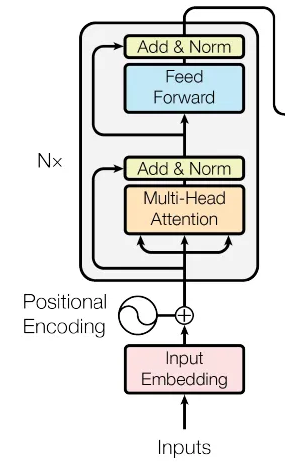

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        # 멀티 헤드 셀프 어텐션 모듈 정의 (자기 자신에 대한 어텐션 계산)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # 위치별 피드포워드 네트워크 정의 (각 단어 위치에 대해 개별적으로 작동)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        # 첫 번째 레이어 정규화 (어텐션 블록 이후 적용)
        self.norm1 = nn.LayerNorm(d_model)
        # 두 번째 레이어 정규화 (피드포워드 블록 이후 적용)
        self.norm2 = nn.LayerNorm(d_model)
        # 드롭아웃 적용 (과적합 방지)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        
        # 1. 입력 x에 대해 자기 자신에 대한 어텐션 계산 (Q=K=V=x)
        attn_output = self.self_attn(x, x, x, mask)
        # 2. 어텐션 결과에 드롭아웃 적용 + 잔차 연결 + 정규화
        x = self.norm1(x + self.dropout(attn_output))
        # 3. 정규화된 x를 피드포워드 네트워크에 통과
        ff_output = self.feed_forward(x)
        # 4. 피드포워드 출력에 드롭아웃 적용 + 잔차 연결 + 정규화
        x = self.norm2(x + self.dropout(ff_output))
        # 5. 최종 인코더 레이어 출력 반환
        return x


### Decoder Layer

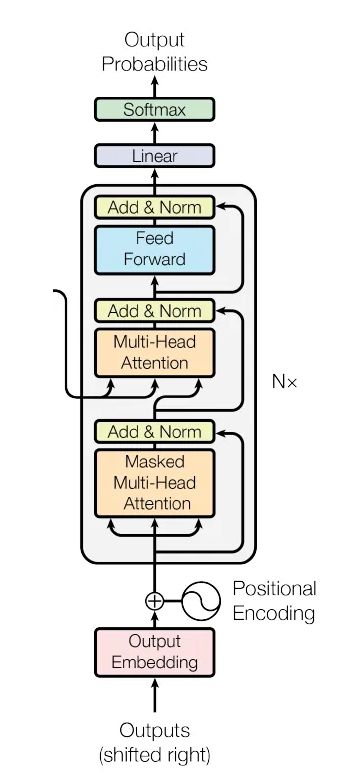

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        # 디코더 내 자기 자신에 대한 어텐션
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # 인코더 출력과의 cross attention
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        # 위치별 Feed Forward 네트워크
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        # 각 단계 후 Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        # Dropout으로 과적합 방지
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        
        # 1. 디코더 입력에 대한 masked self-attention
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        # 2. 인코더 출력과 디코더 입력 간의 cross-attention
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        # 3. 위치별 피드포워드 처리
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x  # 최종 디코더 레이어 출력


### Transformer Model

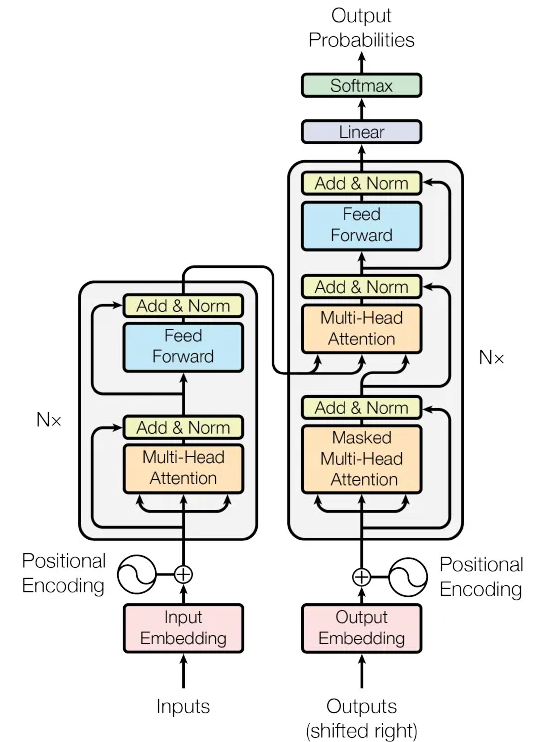

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()

        # 1. 소스 문장을 임베딩 벡터로 변환 (단어 ID → d_model 차원 벡터)
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        # 2. 타겟 문장을 임베딩 벡터로 변환
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # 3. 위치 정보를 임베딩에 추가하기 위한 Positional Encoding 모듈
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # 4. 인코더 레이어를 num_layers만큼 쌓은 모듈 리스트
        #    각 레이어는 Multi-Head Attention + FFN 구조
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        # 5. 디코더 레이어를 num_layers만큼 쌓은 모듈 리스트
        #    각 레이어는 Self-Attention, Cross-Attention, FFN 포함
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # 6. 디코더의 최종 출력 → 단어 확률 분포로 변환 (차원: d_model → tgt_vocab_size)
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        # 7. 드롭아웃은 임베딩과 각 레이어 출력에 적용되어 과적합 방지 역할 수행
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):

        # 패딩 토큰(0)을 마스킹하기 위한 소스 마스크 생성
        # shape: (batch_size, 1, 1, src_seq_len)
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        # 타겟 문장의 패딩 토큰을 마스킹 (디코더 입력용)
        # shape: (batch_size, 1, tgt_seq_len, 1)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)

        seq_length = tgt.size(1) # 타겟 시퀀스 길이

        # 미래 토큰을 마스킹하기 위한 no-peak mask (triu: 상삼각행렬)
        # 예: [0,0,0] → [1,0,0], [1,1,0], [1,1,1]
        # shape: (1, tgt_seq_len, tgt_seq_len)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool() # 미래 정보 마스킹
        
        # 두 마스크를 AND 연산해서
        # (1) padding 토큰 무시
        # (2) 미래 정보 차단
        # → shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)
        tgt_mask = tgt_mask & nopeak_mask

        # 인코더와 디코더에서 사용할 마스크 반환
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # 1. 마스크 생성
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # 2. 임베딩 + 위치 인코딩
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # 3. 인코더 레이어 반복
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # 4. 디코더 레이어 반복
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # 5. 출력층 (단어 예측)
        output = self.fc(dec_output)
        return output


### Hyperparameter Setting and Model Initialization

In [ ]:
# 1. 하이퍼파라미터 설정 (vocab과 시퀀스 길이에 맞춤)
src_vocab_size = len(vocab)       # 단어 사전 크기
tgt_vocab_size = len(vocab)       # 동일하게 사용
d_model = 512                     # 임베딩 차원
num_heads = 8                     # Multi-head 수
num_layers = 6                    # 인코더/디코더 레이어 수
d_ff = 2048                       # FeedForward 차원
max_seq_length = 10              # 우리가 encode할 때 사용한 길이
dropout = 0.1                     # 드롭아웃 비율

# 2. Transformer 모델 초기화
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout
)

# 3. 영어 문장에서 생성된 실제 입력 데이터 사용
src_data = src_tensor  # shape: (10, 10)
tgt_data = tgt_tensor  # shape: (10, 10)
batch_size = src_data.size(0)  # = 10

### Training the Model

In [ ]:
# 손실 함수 정의
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# 모델 학습 모드로 전환
model.train()

# No-Peak 마스크 생성 함수 (디코더용 future masking)
def generate_square_subsequent_mask(seq_len):
    return torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)

# 총 10 에포크 동안 학습
for epoch in range(10):
    optimizer.zero_grad()

    # 1. 입력 마스크 생성
    seq_len = tgt_data.size(1)
    tgt_mask = generate_square_subsequent_mask(seq_len - 1).to(tgt_data.device)

    src_key_padding_mask = (src_data == vocab['<pad>'])          # (batch, src_len)
    tgt_key_padding_mask = (tgt_data[:, :-1] == vocab['<pad>'])  # (batch, tgt_len - 1)

    # 2. 디코더 입력/정답 분리
    decoder_input = tgt_data[:, :-1]     # <sos> A B
    target_output = tgt_data[:, 1:]      # A B <eos>

    # 3. 모델 실행
    output = model(
        src=src_data,
        tgt=decoder_input,
        src_key_padding_mask=src_key_padding_mask,
        tgt_key_padding_mask=tgt_key_padding_mask,
        memory_key_padding_mask=src_key_padding_mask,
        tgt_mask=tgt_mask
    )

    # 4. 손실 계산 (출력: (batch, seq, vocab) → reshape)
    loss = criterion(output.view(-1, len(vocab)), target_output.reshape(-1))

    # 5. 역전파 및 업데이트
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch: 1, Loss: 8.553446769714355
Epoch: 2, Loss: 8.479413986206055
Epoch: 3, Loss: 8.408241271972656
Epoch: 4, Loss: 8.34637451171875
Epoch: 5, Loss: 8.270909309387207
Epoch: 6, Loss: 8.1912202835083
Epoch: 7, Loss: 8.112464904785156
Epoch: 8, Loss: 8.026094436645508
Epoch: 9, Loss: 7.943777561187744
Epoch: 10, Loss: 7.86092472076416


### Transformer prediction -> Post-processing

In [ ]:
# 1. softmax 확률 분포 계산
probs = torch.softmax(output, dim=-1)  # 확률 분포

# 2. 예측 인덱스 선택: argmax
predicted_ids = output.argmax(dim=-1)  # shape: (batch, seq_len)

# 3. 디코딩 함수 정의
def decode_indices(indices, inv_vocab):
    tokens = []
    for idx in indices:
        idx = idx.item()
        if idx == vocab['<eos>']:
            break
        if idx != vocab['<pad>'] and idx != vocab['<sos>']:
            tokens.append(inv_vocab.get(idx, '<unk>'))
    return " ".join(tokens)

# 5. 배치 전체 예측 디코딩
decoded_sentences = []
for i in range(predicted_ids.size(0)):
    decoded = decode_indices(predicted_ids[i], inv_vocab)
    decoded_sentences.append(decoded)

# 6. 예측 결과 비교 출력
print("\n[예측 결과]")
for i in range(len(decoded_sentences)):
    input_text = decode_indices(src_data[i], inv_vocab)
    target_text = decode_indices(tgt_data[i][1:], inv_vocab)  # 정답 시퀀스
    print(f"[입력   {i+1}] {input_text}")
    print(f"[정답   {i+1}] {target_text}")
    print(f"[예측   {i+1}] {decoded_sentences[i]}")
    print()

### END